In [1]:
#%matplotlib inline
import sys
import os


import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import pandas as pd
import networkx as nx
import scipy.optimize as op
import scipy.stats as stt
from sklearn.decomposition import PCA
#optional for nicer plots
import seaborn
clrs = seaborn.color_palette(n_colors=6)
seaborn.set(style='ticks',font_scale=1.5)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

In [3]:
sys.path.append("/Users/yves/Desktop/retreat_data_dir/code/")
from mecll.task import plot_activity_on_graph

In [4]:
import mecll

In [5]:
sys.path.append("/Users/yves/Documents/Code/mec_ephys/packages/mecll/dynamics/")

In [6]:
from unitary_dynamics import *
from unitary_dynamics_loading import *

In [8]:
def fit_dynamics_model(pca_dim: int, pca_activity1: np.ndarray):
    basis_tensor_inf = get_basis_tensor(pca_dim)
    n_params = int(pca_dim*(pca_dim-1)/2)
    params = np.random.normal(size=(n_params))# + np.eye(dim)
    res = op.minimize(predict_all,
                   params,
                   (pca_activity1,pca_dim,basis_tensor_inf),
                   jac=grad_wrapper,
                   method='BFGS'
                   )
    return res

In [7]:
res

NameError: name 'res' is not defined

# Now implement this as a batch thing

In [12]:
def fit_data(neural_activity1,neural_activity2,pca_activity1,pca_activity2,pca):
    pca_dim = pca_activity.shape[1]
    fit_params = []
    fit_quality = []
    for _ in range(5):
        n_params = int(pca_dim*(pca_dim-1)/2)
        basis_tensor_inf = get_basis_tensor(pca_dim)

        params = np.random.normal(size=(n_params))# + np.eye(dim)
        res = op.minimize(predict_all,
                   params,
                   (pca_activity1,pca_dim,basis_tensor_inf),
                   jac=grad_wrapper,
                   method='BFGS'
                   )
        out = res.x
        #out = np.random.normal(size=(n_params))# + np.eye(dim)

        skewM = np.einsum('i...,i...',out,basis_tensor_inf)
        Ainf = caley_transform(skewM,pca_dim)
        #print(res.message)

        predicted_neural_activity = pca.inverse_transform((Ainf@pca_activity1.T).T)
        fit_params.append(out.copy())
        fit_quality.append(evaluate_cc(neural_activity1,predicted_neural_activity))
    #
    params = fit_params[np.nanargmax(fit_quality)]
    skewM = np.einsum('i...,i...',params,basis_tensor_inf)
    Ainf = caley_transform(skewM,pca_dim)
    
    test_seq1_f = get_unique_transitions(seq0,seq1)
    test_seq1_r = get_unique_transitions(seq0,seq1[::-1])
    
    predicted_neural_activity2 = pca.inverse_transform((Ainf@pca_activity2.T).T)
    res = evaluate_cc(neural_activity2[test_seq1_f],predicted_neural_activity2[test_seq1_f])
    res2 = evaluate_cc(neural_activity2[::-1][test_seq1_r],predicted_neural_activity2[::-1][test_seq1_r])
    res = np.nanmax([res,res2])
    shuffle_res = []
    print(res)
    
    
    ntest = len(test_seq1_r)
    print(len(test_seq1_f),len(test_seq1_r))
    r91 = np.arange(len(test_seq1_f))
    r92 = np.arange(len(test_seq1_r))

    for _ in range(500):
        
        perm_order1 = np.random.permutation(r91)
        perm_order2 = np.random.permutation(r92)
        #predicted_neural_activity2 = pca.inverse_transform((Ainf@pca_activity2[perm_order].T).T)
        predicted_neural_activity2_shuff = pca.inverse_transform((Ainf@pca_activity2[::-1].T).T)
        #print(predicted_neural_activity2_shuff[::-1][test_seq1_r])
        
        shf_res = evaluate_cc(neural_activity2[test_seq1_f][perm_order1],
                              predicted_neural_activity2_shuff[test_seq1_f]
                             )
        #print("OK")
        shf_res2 = evaluate_cc(neural_activity2[::-1][test_seq1_r][perm_order2],
                               predicted_neural_activity2_shuff[::-1][test_seq1_r]
                              )
        shuffle_res.append(np.max([shf_res,shf_res2]))
    return res, shuffle_res, Ainf
    

In [ ]:
def evaluate_cc(activity,pred):
    n_neurons = activity.shape[1]
    true_cc = []
    #print(activity[:,0])

    for i in range(n_neurons):
        if (activity[:,i][1:].shape!=pred[:,i][:-1].shape):
            print(activity[:,i][1:].shape,pred[:,i][:-1].shape,i)
        true_cc.append(np.corrcoef(activity[:,i][1:],pred[:,i][:-1])[0,1])

    true_cc = np.nanmean(true_cc)
    return np.nanmean(true_cc)

In [14]:
from sklearn.decomposition import FastICA

In [15]:
#FastICA()

In [30]:
all_res = []
all_shuffle_res = []
for session_ix in range(8):

    firing_rate_maps, frm_stability, task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(session_ix)
    firing_rate_maps = firing_rate_maps[np.array(frm_stability)>.3]
    mds_frm = firing_rate_maps.swapaxes(0,2)
    
    #mds_frm = mds_frm - np.mean(mds_frm,axis=0)[None,...]
    mds_frm = zscore_population_activity(np.vstack(mds_frm))
    act_matrix = mds_frm[:9][seq0] - np.mean(mds_frm[:9][seq0],axis=0)
    act_matrix2 = mds_frm[9:][seq1] - np.mean(mds_frm[9:][seq1],axis=0)

    
    mds_frm = np.dstack([act_matrix,act_matrix2]).swapaxes(0,2).swapaxes(1,2)
    #print(graph_type0,graph_type1)
    pca_dim = 6
    pca = PCA(n_components=pca_dim)
    
    pca.fit(np.vstack(mds_frm))
    pca_activity = pca.transform(mds_frm[0])
    pca_activity2 = pca.transform(mds_frm[1])
    res = fit_data(act_matrix,act_matrix2,pca_activity,pca_activity2,pca)
    all_res.append(res)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0.24848180071060894
7 7


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0.2398160638223593
7 7


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :

0.08106962286674947
7 7


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0.12020461571314044
7 7


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :

0.23617361783144894
9 6


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0.14959405272903453
9 6


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0.04065251611113999
7 9


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


-0.0772474765837347
7 9


In [17]:
Ainf = all_res[-1][0]

In [31]:
Ainf

-0.194451897088497

In [32]:
test_seq1_f = get_unique_transitions(seq0,seq1)
test_seq1_r = get_unique_transitions(seq0,seq1[::-1])

predicted_neural_activity2 = pca.inverse_transform((Ainf@pca_activity2.T).T)
#print(evaluate_cc(act_matrix2[::-1][test_seq1_r],predicted_neural_activity2r[test_seq1_r])[0])

res = evaluate_cc(neural_activity2[test_seq1_f],predicted_neural_activity2[test_seq1_f])
res2 = evaluate_cc(neural_activity2[::-1][test_seq1_r],predicted_neural_activity2[::-1][test_seq1_r])
res = np.max([res,res2])
shuffle_res = []
print(res)



ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [33]:
Ainf.shape

()

In [34]:
seq1[::-1]

array([3, 2, 5, 7, 4, 0, 1, 8, 6])

In [35]:
    test_seq1_f = get_unique_transitions(seq0,seq1)
    test_seq1_r = get_unique_transitions(seq0,seq1[::-1])



In [36]:
test_seq1_r

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [37]:
real_res

[0.2487459793701721,
 0.30500731007852905,
 -0.019507411911912985,
 0.19731642648170336,
 0.22740656995752326,
 0.0780613478817307,
 -0.24571278599193042,
 -0.194451897088497]

In [38]:
real_res = [i[0] for i in all_res]
shuffle_res = [i[1] for i in all_res]

In [39]:
mean_real_pred_accuracy = np.nanmean(real_res)

In [40]:
mean_real_pred_accuracy

0.12984310165009336

0.18760465059933293


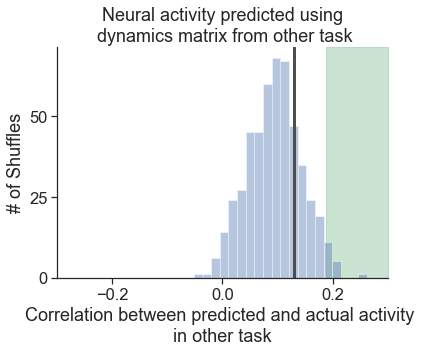

In [41]:
plt.figure(figsize=(6,5))
plt.title("Neural activity predicted using\n dynamics matrix from other task")
seaborn.distplot(np.nanmean(np.array(shuffle_res),axis=0),kde=0)
plt.axvline(x=np.nanmean(real_res),color='.3',linewidth=3)
#plt.annota
seaborn.despine()
plt.xlim(-.3,.3)
yl = plt.gca().get_ylim()
plt.fill_between([np.percentile(np.nanmean(np.array(shuffle_res),axis=0),97.5),.3],[yl[1]]*2,color='g',alpha=.3)
print(np.percentile(np.nanmean(np.array(shuffle_res),axis=0),97.5))
plt.ylim(yl)
plt.xlabel("Correlation between predicted and actual activity \nin other task")
plt.ylabel("# of Shuffles")
plt.locator_params(nbins=3)
plt.tight_layout()

In [91]:
stt.percentileofscore(np.nanmean(shuffle_res,axis=0),np.mean(real_res))

99.2

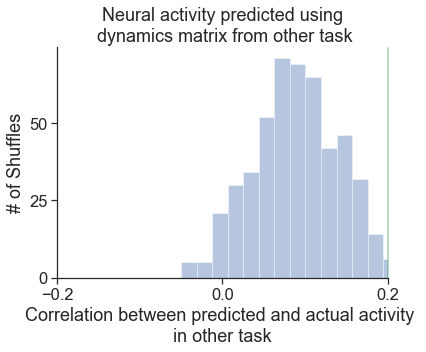

In [92]:
plt.figure(figsize=(6,5))
plt.title("Neural activity predicted using\n dynamics matrix from other task")
seaborn.distplot(np.nanmean(np.array(shuffle_res),axis=0),kde=0)
plt.axvline(x=np.mean(real_res),color='.3',linewidth=3)
#plt.annota
seaborn.despine()
plt.xlim(-.2,.2)
yl = plt.gca().get_ylim()
plt.fill_between([np.percentile(np.nanmean(np.array(shuffle_res),axis=0),97.5),.2],[yl[1]]*2,color='g',alpha=.3)
plt.ylim(yl)
plt.xlabel("Correlation between predicted and actual activity \nin other task")
plt.ylabel("# of Shuffles")
plt.locator_params(nbins=3)
plt.tight_layout()

In [210]:
(100-stt.percentileofscore(np.nanmean(np.array(shuffle_res),axis=0),np.mean(real_res)))/100

0.005999999999999943

In [211]:
(100-stt.percentileofscore(np.nanmean(np.array(shuffle_res),axis=0),np.mean(real_res)))/100

0.005999999999999943

In [212]:
np.std(np.random.normal(size=1000)*.1)

0.09837410750620099

In [213]:
As = np.array([i[2] for i in all_res])

In [218]:
np.abs(As).mean(axis=(0,2))

array([0.29378925, 0.25677421, 0.28263768, 0.31192225, 0.28357026,
       0.29077471, 0.28109692, 0.28486423])

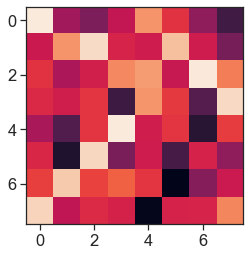

In [222]:
plt.imshow(As[2])

# Unitary dynamics on data no space

In [247]:
def fit_data_no_space(neural_activity1,neural_activity2,pca_activity1,pca_activity2,pca):
    pca_dim = pca_activity.shape[1] - 3
    fit_params = []
    fit_quality = []
    
    pca_activity_no_space1 = pca_activity1[:,3:]
    mu_pca_ns = np.mean(pca_activity1[:,:3],axis=)
    pca_activity_no_space2 = pca_activity2[:,3:]
    for _ in range(5):
        n_params = int(pca_dim*(pca_dim-1)/2)
        basis_tensor_inf = get_basis_tensor(pca_dim)

        params = np.random.normal(size=(n_params))# + np.eye(dim)
        res = op.minimize(predict_all,
                   params,
                   (pca_activity_no_space1,pca_dim,basis_tensor_inf),
                   jac=grad_wrapper,
                   method='BFGS'
                   )
        out = res.x
        #out = np.random.normal(size=(n_params))# + np.eye(dim)

        skewM = np.einsum('i...,i...',out,basis_tensor_inf)
        Ainf = caley_transform(skewM,pca_dim)
        #print(res.message)

        predicted_pca = (Ainf@pca_activity_no_space1.T).T
        #print(predicted_pca.shape)
        predicted_pca = np.hstack([np.zeros([9,3]),predicted_pca])
        predicted_neural_activity = pca.inverse_transform(predicted_pca)
        fit_params.append(out.copy())
        fit_quality.append(evaluate_cc(neural_activity1,predicted_neural_activity))
        
    params = fit_params[np.argmax(fit_quality)]
    skewM = np.einsum('i...,i...',params,basis_tensor_inf)
    Ainf = caley_transform(skewM,pca_dim)

    print(fit_quality)
    
    predicted_pca2 = (Ainf@pca_activity_no_space2.T).T
    predicted_pca2 = np.hstack([np.zeros([9,3]),predicted_pca2])
    predicted_neural_activity2 = pca.inverse_transform(predicted_pca2)
    
    res = evaluate_cc(neural_activity2,predicted_neural_activity2)
    res2 = evaluate_cc(neural_activity2[::-1],predicted_neural_activity2[::-1])
    res = np.max([res,res2])
    shuffle_res = []
    print(res)
    
    r9 = np.arange(9)

    for _ in range(2000):
        
        perm_order = np.random.permutation(r9)
        predicted_pca_shuff = (Ainf@pca_activity_no_space2[perm_order].T).T
        predicted_pca_shuff = np.hstack([np.zeros([9,3]),predicted_pca_shuff])
        
        predicted_neural_activity2_shuff = pca.inverse_transform(predicted_pca_shuff)
        
        shf_res = evaluate_cc(neural_activity2[perm_order],predicted_neural_activity2_shuff)
        shf_res2 = evaluate_cc(neural_activity2[perm_order][::-1],predicted_neural_activity2_shuff[::-1])
        shuffle_res.append(np.max([shf_res,shf_res2]))
    return res, shuffle_res, Ainf
    

In [43]:
np.vstack(mds_frm).shape

(18, 265)

In [45]:
np.mean(np.vstack(mds_frm),axis=0).shape

(265,)

In [248]:
all_res = []
all_shuffle_res = []
for session_ix in range(8):

    firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(session_ix)
    mds_frm = firing_rate_maps.swapaxes(0,2)
    mds_frm = zscore_population_activity(np.vstack(mds_frm))
    act_matrix = mds_frm[:9][seq0] - np.mean(mds_frm[:9][seq0],axis=0)
    act_matrix2 = mds_frm[9:][seq1] - np.mean(mds_frm[9:][seq1],axis=0)

    
    mds_frm = np.dstack([act_matrix,act_matrix2]).swapaxes(0,2).swapaxes(1,2)
    #print(graph_type0,graph_type1)
    pca_dim = 8
    pca = PCA(n_components=pca_dim)
    
    pca.fit(np.vstack(mds_frm))
    pca_activity = pca.transform(mds_frm[0])
    pca_activity2 = pca.transform(mds_frm[1])
    res = fit_data_no_space(act_matrix,act_matrix2,pca_activity,pca_activity2,pca)
    all_res.append(res)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/

[0.21238235027475907, 0.21237939488053542, 0.2124032129303996, 0.14689379231025632, 0.21238333624492478]
0.01331054804276029


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/

[0.25713652400555703, 0.2291669383888642, 0.25710090686019316, 0.25713442424386446, 0.23320573056185065]
0.11689176252799877


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/

[0.19144134149842443, 0.17327069266776698, 0.09654475442263619, 0.19144049235689742, 0.19143948027091284]
-0.040718477355506336


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/

[0.18125534079953692, 0.24206776798713278, 0.25295056521256687, 0.2530415768850891, 0.26275136544668287]
-0.032789691923096886


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/

[0.19221910042402318, 0.19431823709329718, 0.1363134036818495, 0.15927824232568055, 0.19445567974862418]
-0.06992035576699025


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


[0.14656761232842921, 0.146609062755338, 0.14655975495559717, 0.22078153381411314, 0.22074038274140156]
0.022843462427705307


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


[0.2673783129609931, 0.16252186958520246, 0.267379199209248, 0.2673704510259892, 0.2673827112854921]
0.06968232444356827


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/

[0.13976690096984176, 0.1498918971825223, 0.1498957717635513, 0.14988922967575238, 0.10726454107432268]
0.008851448719670155


In [250]:
real_res = [i[0] for i in all_res]
shuffle_res = [i[1] for i in all_res]

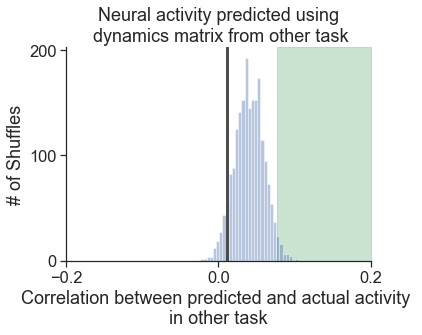

In [251]:
plt.figure(figsize=(6,5))
plt.title("Neural activity predicted using\n dynamics matrix from other task")
seaborn.distplot(np.nanmean(np.array(shuffle_res),axis=0),kde=0)
plt.axvline(x=np.mean(real_res),color='.3',linewidth=3)
#plt.annota
seaborn.despine()
plt.xlim(-.2,.2)
yl = plt.gca().get_ylim()
plt.fill_between([np.percentile(np.nanmean(np.array(shuffle_res),axis=0),97.5),.2],[yl[1]]*2,color='g',alpha=.3)
plt.ylim(yl)
plt.xlabel("Correlation between predicted and actual activity \nin other task")
plt.ylabel("# of Shuffles")
plt.locator_params(nbins=3)
plt.tight_layout()


# To do list

1. Check which PCs are well predicted by the transition matrix.
2. Check whether distance between ports calculates with performance of the predictions on trial 2

In [ ]:
import pandas as pd
df = pd.read_csv("/Users/Yves/Desktop/HO_returns.csv")
group_data = df.groupby(['Species',
                     'Start date',
                     'End date',
                     'Protocol',
                     'Supplier',
                     'Place of birth',
                     'WT/GM',
                     'Purpose',
                     'Sub-purpose',
                     'Retrospective severity',
                     'Procedures',
                     'Anaesthesia',
                     'Fate',
                     #'Comments'
                    ])
df2 = pd.DataFrame(group_data.size().reset_index(name = "Group_Count"))
df2.rename(columns = {'Group_Count':'Number of animals'}, inplace = True)
df2['Comments'] = ''
col_order = ['Species','Number of animals','Start date',
            'End date','Protocol','Supplier',
            'Place of birth','WT/GM','Purpose','Sub-purpose',
            'Retrospective severity','Procedures',
            'Anaesthesia','Fate','Comments']
df2 = df2.reindex(col_order, axis=1)

In [14]:

df2

NameError: name 'df2' is not defined